In [ ]:
!git clone https://github.com/vkhoi/KTH-Action-Recognition.git

Cloning into 'KTH-Action-Recognition'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 709.16 KiB | 11.26 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
%cd /content/KTH-Action-Recognition/dataset

/content/KTH-Action-Recognition/dataset


In [ ]:
!wget http://www.nada.kth.se/cvap/actions/boxing.zip
!wget http://www.nada.kth.se/cvap/actions/handclapping.zip
!wget http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget http://www.nada.kth.se/cvap/actions/jogging.zip
!wget http://www.nada.kth.se/cvap/actions/running.zip
!wget http://www.nada.kth.se/cvap/actions/walking.zip

--2021-05-11 16:34:38--  http://www.nada.kth.se/cvap/actions/boxing.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/boxing.zip [following]
--2021-05-11 16:34:38--  https://www.csc.kth.se/cvap/actions/boxing.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194498294 (185M) [application/zip]
Saving to: ‘boxing.zip’

boxing.zip          100%[===================>] 185.49M  1.10MB/s    in 2m 52s  

2021-05-11 16:37:31 (1.08 MB/s) - ‘boxing.zip’ saved [194498294/194498294]

--2021-05-11 16:37:31--  http://www.nada.kth.se/cvap/actions/handclapping.zip
Resolving www.nada.kth.se (www.nada.kth.

In [ ]:
!unzip boxing.zip -d boxing
!unzip handclapping.zip -d handclapping
!unzip handwaving.zip -d handwaving
!unzip jogging.zip -d jogging
!unzip running.zip -d running
!unzip walking.zip -d walking

!rm *.zip

Archive:  boxing.zip
  inflating: boxing/person01_boxing_d1_uncomp.avi  
  inflating: boxing/person01_boxing_d2_uncomp.avi  
  inflating: boxing/person01_boxing_d3_uncomp.avi  
  inflating: boxing/person01_boxing_d4_uncomp.avi  
  inflating: boxing/person02_boxing_d1_uncomp.avi  
  inflating: boxing/person02_boxing_d2_uncomp.avi  
  inflating: boxing/person02_boxing_d3_uncomp.avi  
  inflating: boxing/person02_boxing_d4_uncomp.avi  
  inflating: boxing/person03_boxing_d1_uncomp.avi  
  inflating: boxing/person03_boxing_d2_uncomp.avi  
  inflating: boxing/person03_boxing_d3_uncomp.avi  
  inflating: boxing/person03_boxing_d4_uncomp.avi  
  inflating: boxing/person04_boxing_d1_uncomp.avi  
  inflating: boxing/person04_boxing_d2_uncomp.avi  
  inflating: boxing/person04_boxing_d3_uncomp.avi  
  inflating: boxing/person04_boxing_d4_uncomp.avi  
  inflating: boxing/person05_boxing_d1_uncomp.avi  
  inflating: boxing/person05_boxing_d2_uncomp.avi  
  inflating: boxing/person05_boxing_d3_unco

In [ ]:
##CODE FOR EXTRACTING OPTICALFLOW VALUES as features and clustering and storing as feature files all categories in one pickle file
import cv2
import numpy as np
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans


CATEGORIES = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]

if __name__ == "__main__":

    # Create directory to store extracted SIFT features.
    os.makedirs("data", exist_ok=True)

    # Setup parameters for optical flow.
    farneback_params = dict(winsize = 20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

    n_processed_files = 0
    features = []

    for category in CATEGORIES:
        print("Processing category %s" % category)

        # Get all files in current category's folder.
        folder_path = os.path.join("..", "dataset", category)
        filenames = os.listdir(folder_path)

        # List to store features. features[i] stores features for the i-th video
        # in current category.
        #features = []

        for filename in filenames:
            filepath = os.path.join("..", "dataset", category, filename)
            path = "/content/KTH-Action-Recognition/dataset/" + category + "/" + filename
            vid = cv2.VideoCapture(filepath)

            # Store features in current file.
            features_current_file = []

            prev_frame = None

            while vid.isOpened():
                ret, frame = vid.read()
                if not ret:
                    break

                # Only care about gray scale.
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                if prev_frame is not None:
                    # Calculate optical flow.
                    flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,
                        **farneback_params)

                    feature = []
                    for r in range(120):
                        if r % 10 != 0:
                            continue
                        for c in range(160):
                            if c % 10 != 0:
                                continue
                            feature.append(flows[r,c,0])
                            feature.append(flows[r,c,1])
                    feature = np.array(feature)

                    features_current_file.append(feature)

                prev_frame = frame
            
            kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
            pred_y = kmeans.fit_predict(features_current_file)

            #print(pred_y)
            feature_new = np.array(kmeans.cluster_centers_)
            print(feature_new)           
            features.append({
                "filename": filename,
                "path" : path,
                "category": category,
                "features": feature_new 
            })

            n_processed_files += 1
            if n_processed_files % 30 == 0:
              print("Done %d files" % n_processed_files)

        # Dump data to file.
#pickle.dump(features, open("data/optflow_%s.p" % category, "wb"))
pickle.dump(features, open("data/optflow_cluster_4.p" , "wb"))




Processing category boxing
[[ 0.00017751  0.00063603  0.01713242 ...  0.03227902  0.01730616
   0.0376312 ]
 [ 0.00027444  0.0005411   0.00364398 ... -0.02177657  0.04767136
  -0.02302384]
 [ 0.00055462  0.00057854  0.02995183 ...  0.00298327  0.08444978
   0.00823971]
 [ 0.00031389  0.00051589  0.00556676 ...  0.0042593   0.03368976
  -0.00598058]]
[[ 0.00113359  0.00150908  0.00879621 ...  0.03575438 -0.01007118
   0.01918468]
 [ 0.00127265  0.00142016  0.01464103 ... -0.00359336  0.01741664
  -0.00143138]
 [ 0.0014845   0.00205953  0.04129504 ... -0.0235812   0.01008329
  -0.02192493]
 [ 0.00167015  0.0015606   0.01744864 ...  0.01768086  0.00191289
   0.01566555]]
[[-1.25352277e-04  2.71414434e-04 -8.68390346e-03 ... -2.44244572e-01
  -1.27182474e-01 -2.15671917e-01]
 [ 3.25480753e-03  4.20890809e-04  8.91824213e-02 ... -3.35322950e-01
  -2.11473647e-01 -2.89746833e-01]
 [ 8.28670646e-04  2.23805031e-04  4.89841191e-02 ...  7.02799786e-01
   4.64022325e-01  5.01855371e-01]
 [ 2.119

In [ ]:
print(len(features))
print(features[0])

Streaming output truncated to the last 5000 lines.
       -8.99925753e-02, -1.98256448e-02, -1.49136418e-02,  9.43696871e-02,
        2.46602464e-02,  1.48118839e-01, -4.97440696e-02,  5.52135855e-02,
       -4.83681709e-02,  2.33923141e-02, -8.83796364e-02,  3.50250565e-02,
       -8.86502117e-02,  2.31478531e-02, -1.47019364e-02,  4.47973981e-02,
        3.49616893e-02,  5.92464954e-02,  3.56813110e-02,  4.51624729e-02,
       -1.05801769e-01,  9.89899114e-02, -2.50607908e-01, -1.04750870e-02,
       -6.98700026e-02,  1.78170186e-02, -1.93593472e-01, -9.92738269e-03],
      dtype=float32), array([ 4.33961162e-04,  5.73866018e-05,  2.31401320e-03,  1.23301577e-02,
       -8.59348252e-02, -4.68572304e-02,  1.16921589e-01, -1.55399954e-02,
       -3.66961956e-02,  7.76324654e-03, -8.16591084e-03,  1.04416069e-02,
       -6.62109032e-02,  3.22602652e-02,  4.96458970e-02,  2.09917083e-01,
        4.33337176e-03,  1.29164591e-01,  1.05236925e-01,  8.72371048e-02,
       -9.45274811e-03,  1

In [ ]:
#EXTRACTING OPTICAL FLOW FROM QUERY VIDEO and doing clustering to get important features
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans


# Setup parameters for optical flow.
farneback_params = dict(winsize = 20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

#QUERY VIDEO
filepath = '/content/KTH-Action-Recognition/dataset/person01_boxing_d1_uncomp.avi'
vid = cv2.VideoCapture(filepath)

            # Store features in current file.
features_current_file_new = []
count_frame = 0
prev_frame = None
while vid.isOpened():
  ret, frame = vid.read()
  count_frame = count_frame + 1
  if not ret:
    break
  # Only care about gray scale.
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #print(frame)
  if(prev_frame is not None):

    flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,**farneback_params)
    #print(flows)
    feature = []
    for r in range(120):
      if r % 10 != 0:
        continue
      for c in range(160):
          if c % 10 != 0:
            continue
          feature.append(flows[r,c,0])
          feature.append(flows[r,c,1])
    feature = np.array(feature)
    features_current_file_new.append(feature)
  prev_frame = frame

features_current_file_new = np.array(features_current_file_new)
print((features_current_file_new))
print(len(features_current_file_new))

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(features_current_file_new)

print(pred_y)
feature_new = np.array(kmeans.cluster_centers_)
print(feature_new)           

[[ 7.8166826e-03  3.4231893e-03  2.6740524e-01 ... -4.8670912e-01
   6.2397450e-01 -4.9285766e-01]
 [-4.0252600e-03 -1.1776921e-03 -1.5639985e-01 ... -4.0303272e-01
   6.3305277e-01 -2.5876136e-02]
 [ 4.5227460e-03  1.3972573e-03  4.1264611e-01 ... -1.6061094e-01
   1.0275143e+00 -4.1646546e-01]
 ...
 [ 3.0660150e-03  1.3695725e-03 -9.4729196e-04 ...  1.2635972e-01
   3.1656723e-02  1.4707133e-01]
 [ 2.2545261e-03 -9.3073258e-04 -2.9423307e-03 ...  1.6303776e-02
   1.4981611e-01  2.8002553e-02]
 [ 2.7173855e-03  1.3366659e-03  9.8391704e-02 ...  1.7796101e-01
   6.6315785e-02  2.7740267e-01]]
359
[1 1 2 2 2 2 0 0 1 1 2 2 2 1 1 1 2 2 2 0 0 0 0 1 2 2 2 1 1 1 2 2 3 3 0 0 0
 1 1 2 2 2 1 1 1 2 2 3 0 0 0 1 2 2 2 1 1 1 1 2 3 3 0 0 0 1 2 2 2 2 1 1 1 3
 3 3 0 0 0 1 2 2 2 2 1 1 1 2 3 3 0 0 0 1 1 2 2 2 1 1 1 2 2 3 0 0 0 1 1 2 2
 2 1 1 1 2 2 3 0 0 0 1 2 2 2 2 1 1 1 2 2 2 0 0 0 1 2 2 2 2 1 1 1 2 2 3 0 0
 0 1 1 2 2 2 1 1 1 2 2 3 0 0 0 0 1 2 2 2 1 1 1 2 2 3 3 0 0 0 0 1 2 2 2 1 1
 1 2 3 3 0 0 0 1 1 2 

In [ ]:
#CBVR SAMPLE TEST BENCH FOR OPTICAL FLOW + Clustering BASED COMPARISONS
#Accessing the feature database
import pickle
import cv2
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans



# List to store result
feature_result = []

#CODE TO EXTRACT FEATURES FROM QUERY IMAGE


#QUERY VIDEO
#QUERY VIDEO
# Setup parameters for optical flow.


# Setup parameters for optical flow.
farneback_params = dict(winsize = 20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

#QUERY VIDEO
filepath = '/content/KTH-Action-Recognition/dataset/boxing/person01_boxing_d1_uncomp.avi'
vid = cv2.VideoCapture(filepath)

            # Store features in current file.
features_current_file_new = []
count_frame = 0
prev_frame = None
while vid.isOpened():
  ret, frame = vid.read()
  count_frame = count_frame + 1
  if not ret:
    break
  # Only care about gray scale.
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #print(frame)
  if(prev_frame is not None):

    flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,**farneback_params)
    #print(flows)
    feature = []
    for r in range(120):
      if r % 10 != 0:
        continue
      for c in range(160):
          if c % 10 != 0:
            continue
          feature.append(flows[r,c,0])
          feature.append(flows[r,c,1])
    feature = np.array(feature)
    features_current_file_new.append(feature)
  prev_frame = frame

features_current_file_new = np.array(features_current_file_new)
print((features_current_file_new))
print(len(features_current_file_new))

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(features_current_file_new)

#print(pred_y)
feature_new = np.array(kmeans.cluster_centers_)
print(feature_new)                       





# open a file, where you stored the pickled data
file = open('/content/KTH-Action-Recognition/dataset/data/optflow_cluster_4.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')


cnt = 0
for item in data:
    #print('The data ', cnt, ' is : ', item['path'])
    print('The data ', cnt, ' is : ', len(item['features']))

    
    point_a = np.array(item['features'])
    point_b = np.array(feature_new)

    distance = np.linalg.norm(point_a - point_b)
    print(distance)
    
    feature_result.append({
                
                "path" : item['path'],
                "similarity" : distance,
                "category" : item['category'] 
            })

    cnt += 1

print(feature_result)
df = DataFrame (feature_result)
print (df)



df1 = df.sort_values(by=['similarity'])
print(df1)



[[ 7.8166826e-03  3.4231893e-03  2.6740524e-01 ... -4.8670912e-01
   6.2397450e-01 -4.9285766e-01]
 [-4.0252600e-03 -1.1776921e-03 -1.5639985e-01 ... -4.0303272e-01
   6.3305277e-01 -2.5876136e-02]
 [ 4.5227460e-03  1.3972573e-03  4.1264611e-01 ... -1.6061094e-01
   1.0275143e+00 -4.1646546e-01]
 ...
 [ 3.0660150e-03  1.3695725e-03 -9.4729196e-04 ...  1.2635972e-01
   3.1656723e-02  1.4707133e-01]
 [ 2.2545261e-03 -9.3073258e-04 -2.9423307e-03 ...  1.6303776e-02
   1.4981611e-01  2.8002553e-02]
 [ 2.7173855e-03  1.3366659e-03  9.8391704e-02 ...  1.7796101e-01
   6.6315785e-02  2.7740267e-01]]
359
[[ 1.0593296e-03  1.7593588e-03  2.7486525e-02 ...  1.3979249e-02
   9.3918871e-03  4.8641679e-03]
 [ 7.3942088e-04  1.4773109e-03  4.2090230e-03 ...  1.0209568e-02
   1.6598867e-02  1.5634907e-02]
 [ 1.3458012e-03  1.8247922e-03  2.2544252e-02 ...  2.9435963e-03
   2.8494608e-02  3.6715993e-03]
 [ 1.0584323e-03  1.2769763e-03  9.4512608e-03 ... -1.2665278e-02
   2.8640408e-02  6.7121815e-05]]

In [ ]:
#MEAN AVERAGE PRECISION
import matplotlib.pyplot as plt

TP = 0

Total = len(df1) 
print(Total)
res = []
query = 'boxing'
#for i in range(0,Total):
for index, row in df1.iterrows():
  #print(row['category'])
  res.append(row['category'])
print(res)
print(len(res))

map = []
for i in range(0,len(res)):
  if(res[i] == query):
    map.append(1)
  else:
    map.append(0)

print(map)  

map_fet = []
mar_fet = []
mTP = 0

mTR = 0
for i in range(0,len(map)):
  TP = TP + map[i]
  mTP = TP / (i+1)
  mTR = TP / (100)
  map_fet.append(mTP)
  mar_fet.append(mTR)
  mTP = 0



print(map_fet)
print(mar_fet)



599
['boxing', 'boxing', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'boxing', 'handclapping', 'walking', 'boxing', 'handclapping', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'boxing', 'handclapping', 'handclapping', 'boxing', 'handclapping', 'handclapping', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'boxing', 'handclapping', 'handclapping', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'handwaving', 'handclapping', 'walking', 'handclapping', 'handwaving', 'walking', 'handclapping', 'walking', 'walking', 'handclapping', 'boxing', 'handclapping', 'boxing', 'boxing', 'handclapping', 'boxing', 'walking', 'boxing', 'boxing', 'boxing', 'handclapping

[[40 47  6  0  0  7]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


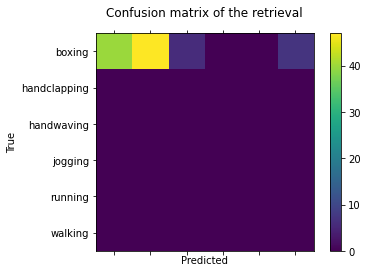

              precision    recall  f1-score   support

      boxing       1.00      0.40      0.57       100
handclapping       0.00      0.00      0.00         0
  handwaving       0.00      0.00      0.00         0
     jogging       0.00      0.00      0.00         0
     running       0.00      0.00      0.00         0
     walking       0.00      0.00      0.00         0

   micro avg       0.40      0.40      0.40       100
   macro avg       0.17      0.07      0.10       100
weighted avg       1.00      0.40      0.57       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#CONFUSION MATRIX
# Importing the dependancies
from sklearn import metrics
# Predicted values

y_pred = []
y_act = []
#y_pred = ["boxing", "boxing", "handclapping", "boxing", "handclapping"]

for i in range(0,100):
  y_pred.append(res[i])

# Actual values
#y_act = ["boxing", "boxing", "boxing", "boxing", "boxing"]

for i in range(0,100):
  y_act.append("boxing")
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
labels=["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]
print(metrics.confusion_matrix(y_act, y_pred, labels))
# Printing the precision and recall, among other metrics
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(metrics.confusion_matrix(y_act, y_pred, labels))
plt.title('Confusion matrix of the retrieval')
fig.colorbar(cax)
ax.set_xticklabels([''])
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#print(metrics.classification_report(y_act, y_pred, labels=["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]))

[[14  6]
 [ 0  0]]


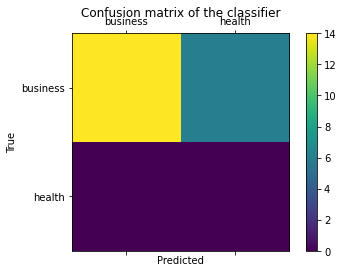

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


y_test=['business', 'business', 'business', 'business', 'business',
        'business', 'business', 'business', 'business', 'business',
        'business', 'business', 'business', 'business', 'business',
        'business', 'business', 'business', 'business', 'business']
pred=['health', 'business', 'business', 'business', 'business',
       'business', 'health', 'health', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'health', 'health', 'business', 'health']


labels = ['business', 'health']
cm = confusion_matrix(y_test, pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#CONFUSION MATRIX
# Importing the dependancies
from sklearn import metrics
# Predicted values
y_pred = ["a", "b", "c", "a", "b"]
# Actual values
y_act = ["a", "b", "c", "c", "a"]
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(y_act, y_pred, labels=["a", "b", "c"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["a", 
"b","c"]))

[[1 1 0]
 [0 1 0]
 [1 0 1]]
              precision    recall  f1-score   support

           a       0.50      0.50      0.50         2
           b       0.50      1.00      0.67         1
           c       1.00      0.50      0.67         2

    accuracy                           0.60         5
   macro avg       0.67      0.67      0.61         5
weighted avg       0.70      0.60      0.60         5



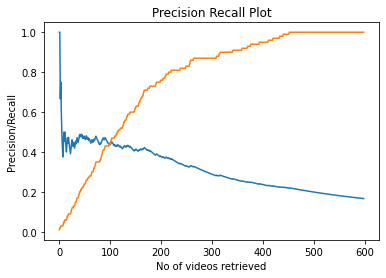

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import math #needed for definition of pi
x = np.arange(0, len(res), 1)
y1 = map_fet
y2 = mar_fet
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel("No of videos retrieved")
plt.ylabel("Precision/Recall")
plt.title('Precision Recall Plot')
plt.show()

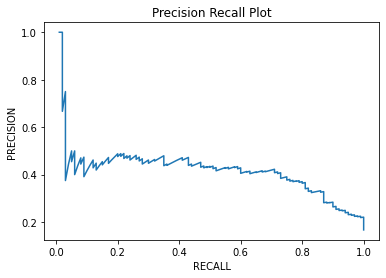

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import math #needed for definition of pi
x = np.arange(0, len(res), 1)
y1 = map_fet
y2 = mar_fet
#plt.plot(x,y1)
plt.plot(y2,y1)
plt.xlabel("RECALL")
plt.ylabel("PRECISION")
plt.title('Precision Recall Plot')
plt.show()